## Numerical Solution of LWR model:

Lighthill-Whitham-Richards model (commonly used for traffic flow):

\begin{equation}
\frac{\partial q}{\partial x} + \frac{\partial k}{\partial t} = 0
\end{equation}

But $q$ is a function of $k$ (Greenshield model): 
$$
q(k) = k(k_j - k) = k k_j -k^2
$$

Therefore
$$
\frac{\partial k}{\partial t} + \frac{dq}{dk}\frac{\partial k}{\partial x} =0
$$

$$
\frac{d(q(k))}{dk} = 1(k_j - k) + k(-1) = k_j - 2k
$$

And
$$
\frac{\partial k}{\partial t} + (k_j - 2k) \frac{\partial k}{\partial x} = 0
$$

C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_9916/4047686461.py:11: RuntimeWarning: invalid value encountered in true_divide
  v=q/k


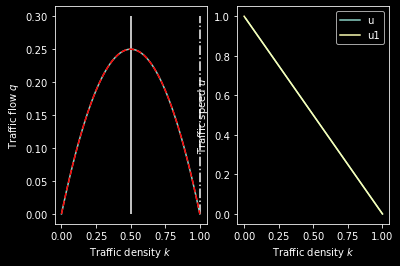

In [1]:
# k can never be higher than kj, which is the jam density.
# Therefore, using k > kj results in instabilities!
def greenshield(k, kj=1.):
    q=k*(kj-k)
    return q

import numpy as np
k=np.arange(0., 1.01, 0.01)
import matplotlib.pyplot as plt
q=greenshield(k)
v=q/k

kj=1
vf=1
#verifying equation 6 from Gaddam(15)
#v1 is speed at low traffic density or low flow
v1=vf*(1.-(k/kj))
plt.style.use('dark_background')
fig,ax=plt.subplots(ncols=2)
q1=k*v1
ax[0].plot(k,q)
ax[0].plot(k,q1, color='red', linestyle='dashed')
ax[0].vlines(0.5, 0, 0.30)
ax[0].vlines(1.0, 0, 0.30, linestyle='dashdot')
ax[0].set_xlabel("Traffic density $k$")
ax[0].set_ylabel("Traffic flow $q$")

ax[1].plot(k,v, label='u')
ax[1].plot(k,v1, label='u1')
ax[1].set_xlabel("Traffic density $k$")
ax[1].set_ylabel("Traffic speed $u$")
ax[1].legend()

$$
\frac{\partial k}{\partial t} = (2k - k_j) \frac{\partial k}{\partial x}
$$

\begin{equation}
\frac{k(t+\Delta t, x_n) - k(t, x_n)}{\Delta t} =  \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{equation}

\begin{align}
k(t + \Delta t, x_n) =& k(t, x) + \Delta t \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{align}

\begin{align}
\frac{\partial{k}}{\partial x} \approx \frac{k(t, x + \Delta x) - k(t,x - \Delta x)}{2 \Delta x} \\
                               \approx \frac{k(t, x + \Delta x) - k(t, x)}{\Delta x} \\
\end{align}

If I remember correctly the central difference formula is unstable when used with the forward time step, 
but I will check into this.

**Update:** Yes, that's correct.  See Gaddam *et al.*., 2015.  Only the upwind scheme is stable, downwind and central are unstable.  Alternative leapfrog 
or higher order methods are mentioned in this reference.

Discretizing along t_i for i=0,$n_t$ and x_n for n=0, $n_x$.
$k_n^i$ equals the traffic density at time $t_i$ and position $n_i$.

Sampling rates are $\Delta t$ and $\Delta x$, respectively.
$k_j(x)$ is location dependent.  Call it $\kappa_n$.

$$
k_n^{i+1} = k_n^i + \Delta t  (2 k_n^i - \kappa_n) \frac{k_{n+1}^i - k_n^i}{\Delta x}
$$

In a real world scenario, we wouldn't have data at every point along the discretized distance.
This is different from the scenario tested here.  Therefore, the functions needs to be modified
to internally calculate points with the discretization distance needed to fulfill the stability criterion, while outputting predictions only where data is available.

In [2]:
import numpy as np

## Considerations for time and grid step in numerical solution

The CFL condition applies:

\begin{equation}
C = \frac{v_f \Delta t}{\Delta x} \leq C_\max,
\end{equation}

where $C_\max = 1$.

Using $v_f$ = 32 m/s and $\Delta x$ = 300 m, $\Delta t$ needs to be smaller or equal to 9.375 s to meet the CFL condition:

\begin{equation}
\Delta t = \frac{C \Delta x}{v_f} = \frac{1.0 \cdot 300 \text{ m}}{32 \text{ m/s}} = 9.375s
\end{equation}

I'm using $\Delta t$ = 6 s such that the sampling in the data (5 minutes or 300 s) is a multiple of $\Delta t$.  Therefore, one of 50 timesteps is being output by the solver (`tskip = 100`).

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [4]:
import torch 
import torch.nn as nn

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [7]:
import torch.nn.functional as F

class PiecewiseLinearModel(nn.Module):
    def __init__(self, n_breaks, num_regions):
        super(PiecewiseLinearModel, self).__init__()

#         x = torch.tensor(x.astype(np.float32)).repeat(n_breaks, 1)
#         x = x.permute(1, 0)
#         x = x.unsqueeze(1)
#         self.breaks = nn.Parameter(x)
#         print(x.shape)
        self.breaks = nn.Parameter((0.3 - 0.2) * torch.rand((num_regions, 1, n_breaks)) + 0.2)
# (max-min)*torch.rand((2, 5)) + min
#         print(self.breaks.shape)
        self.linear = nn.Linear(n_breaks + 1, 1) 
    def forward(self, xx):
#         print(xx.shape)
        if len(xx.shape) < 3:
            xx = xx.unsqueeze(-1)
        out = torch.cat([xx, F.relu(xx - self.breaks)],2)
        print(xx - self.breaks)
#         print(F.relu(xx - self.breaks))
        print(out.shape)
        return self.linear(out).squeeze(-1)

In [60]:
import torch.nn.functional as F

class PiecewiseLinearModel(nn.Module):
    def __init__(self, n_breaks, num_regions):
        super(PiecewiseLinearModel, self).__init__()
        self.breaks = nn.Parameter(torch.rand((num_regions, 1, n_breaks)))
        self.linear = nn.Linear(n_breaks + 1, 1) 
    def forward(self, xx): 
        if len(xx.shape) < 3: 
            xx = xx.unsqueeze(-1)
        out = torch.cat([xx, F.relu(xx - self.breaks)],2)
#         print(out.shape)
        return self.linear(out).squeeze(-1)

In [176]:
t = torch.tensor(np.arange(1, 120)).repeat(32, 1)

In [177]:
t.shape

torch.Size([32, 119])

In [175]:
np.arange(1, 100).shape

(99,)

In [59]:
tt, tt.shape

(tensor([[1, 2],
         [3, 1],
         [2, 3]]),
 torch.Size([3, 2]))

In [180]:
plm = PiecewiseLinearModel(2, 120)
out = plm(t)

tensor([[[ 0.7509,  0.7238],
         [ 1.7509,  1.7238],
         [ 2.7509,  2.7238],
         ...,
         [96.7509, 96.7238],
         [97.7509, 97.7238],
         [98.7509, 98.7238]],

        [[ 0.7501,  0.7318],
         [ 1.7501,  1.7318],
         [ 2.7501,  2.7318],
         ...,
         [96.7501, 96.7318],
         [97.7501, 97.7318],
         [98.7501, 98.7318]],

        [[ 0.7645,  0.7864],
         [ 1.7645,  1.7864],
         [ 2.7645,  2.7864],
         ...,
         [96.7645, 96.7864],
         [97.7645, 97.7864],
         [98.7645, 98.7864]],

        ...,

        [[ 0.7954,  0.7535],
         [ 1.7954,  1.7535],
         [ 2.7954,  2.7535],
         ...,
         [96.7954, 96.7535],
         [97.7954, 97.7535],
         [98.7954, 98.7535]],

        [[ 0.7571,  0.7294],
         [ 1.7571,  1.7294],
         [ 2.7571,  2.7294],
         ...,
         [96.7571, 96.7294],
         [97.7571, 97.7294],
         [98.7571, 98.7294]],

        [[ 0.7978,  0.7571],
       

In [253]:
torch.linspace(0, 1, 100)

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [182]:
out[:, 1]

tensor([1.2987, 1.2982, 1.3056, 1.2781, 1.2729, 1.2750, 1.3229, 1.2961, 1.2941,
        1.2866, 1.3211, 1.2923, 1.3196, 1.2946, 1.3077, 1.2878, 1.2933, 1.3053,
        1.3224, 1.3210, 1.2991, 1.3022, 1.2779, 1.2776, 1.3157, 1.3198, 1.2807,
        1.2773, 1.3194, 1.2950, 1.2819, 1.2954, 1.2775, 1.2860, 1.3057, 1.2768,
        1.2835, 1.2794, 1.2926, 1.3007, 1.3237, 1.2710, 1.2787, 1.3234, 1.3113,
        1.2720, 1.2826, 1.3030, 1.2866, 1.2993, 1.2997, 1.2822, 1.3241, 1.2748,
        1.3152, 1.2804, 1.3115, 1.2966, 1.3223, 1.3202, 1.2747, 1.2956, 1.3003,
        1.2729, 1.3062, 1.3252, 1.2802, 1.2735, 1.3228, 1.3209, 1.2866, 1.3199,
        1.3022, 1.2720, 1.2704, 1.2798, 1.3228, 1.2734, 1.2817, 1.2780, 1.3213,
        1.3017, 1.2736, 1.2841, 1.2923, 1.3125, 1.2837, 1.2706, 1.3070, 1.3059,
        1.2812, 1.3103, 1.3156, 1.2726, 1.3248, 1.2924, 1.2829, 1.3123, 1.2771,
        1.2873, 1.3089, 1.3236, 1.2915, 1.2873, 1.3130, 1.2879, 1.2917, 1.3040,
        1.3038, 1.2988, 1.2834, 1.2987, 

In [138]:
class Neural_LWR_sparse2_3cmp(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, xi, tskip, plm = "initial", initial='random', boundary='zeros',
                fix_vf=False, parstep=1):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip 
            
        super(Neural_LWR_sparse2_3cmp, self).__init__()
        
        self.cmps=["k","q","u"]  #density, flow, velocity
        self.initial={}
        self.boundary={}
        
#         if initial == 'random':
#             self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["q"] = self.initial["k"] * self.initial["v"]
#         elif initial == 'zeros':
#             for c in self.cmps:
#                 self.initial[c] = torch.zeros(nx, requires_grad=True).double()
#         else:
#             assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
#             for c in self.cmps:
#                 self.initial[c] = torch.tensor(initial[c])
            
#         # influx at upstream border - needs to be known or assumed
#         if boundary == 'zeros':
#             for c in self.cmps:
#                 self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
#         else:
#             assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
#             for c in self.cmps:
#                 self.boundary[c] = torch.tensor(boundary[c])
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        
        # use piecewise linear function for kj
        if plm == "none": 
            self.kappa = torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
#             print(self.kappa, self.kappa.shape)
        elif plm == "initial": 
            self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx) 
        else: 
            self.plm = plm
        
        #characteristic velocity vf
        if not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
#             print(self.vf, self.vf.shape)
#             self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx, x = vf)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, initial, boundary, tsteps): 
#         self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        if initial == 'random':
            self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["q"] = self.initial["k"] * self.initial["v"]
        elif initial == 'zeros':
            for c in self.cmps:
                self.initial[c] = torch.zeros(nx, requires_grad=True).double()
        else:
            assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
            for c in self.cmps:
                self.initial[c] = torch.tensor(initial[c])
            
        # influx at upstream border - needs to be known or assumed
        if boundary == 'zeros':
            for c in self.cmps:
                self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
        else:
            assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
            for c in self.cmps:
                self.boundary[c] = torch.tensor(boundary[c])       
        
        nt=len(tsteps) 
#         t = torch.linspace(0, 1, nt).repeat(self.nx, 1)
#         kappa = self.plm(t)
        self.k=[self.initial["k"]]   # density
        self.u=[self.initial["u"]]   # velocity
        self.q=[self.initial["q"]]   # flow
        
        #initial values at output points
        self.ki=[self.initial["k"][self.xi]]
        self.ui=[self.initial["u"][self.xi]]
        self.qi=[self.initial["q"][self.xi]]
        
        for n in range(1, nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros(nx, requires_grad=True).double()
            nu=torch.zeros(nx, requires_grad=True).double()
            nq=torch.zeros(nx, requires_grad=True).double()

            #new values for 3 variables stored in one tensor per time step
            nk[0] = self.boundary["k"][n]
            nu[0] = self.boundary["u"][n]
            nq[0] = self.boundary["q"][n]
                                  
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
            hkappa=self.kappa[idx.long()]
#             hkappa = kappa[:, n - 1]
#             print(hkappa, hkappa.shape)
            hvf=self.vf[idx.long()]
#             print(hkappa.shape, hvf.shape)
            
#             print(self.q[n-1][0], nq[0]) 
            ### 
            # Method of lines + RK4 method 
            # dt * f(t[n], y[n]) 
#             k1_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) # central difference 
#             print(self.k[n-1][1:].shape, nk[0].shape, nk[0].unsqueeze(0).shape)
            k1_k = - (self.q[n-1][1:] - self.q[n-1][:-1]) / self.dx # finite difference 
#             print(k1_k.shape) 
            nk_1 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
            nu_1 = hvf[1:] * (1 - nk_1[1:] / hkappa[1:]) 
            nq_1 = nk_1[1:] * nu_1
            nq_1 = torch.cat((nq[0].unsqueeze(0), nq_1)) 

#             print(self.k[n-1])
            # dt * f(t[n] + dt/2, y[n] + k1/2) 

#             nk_1 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
#             print(k1_k)
# #             print(nk[1:])
#             print(nk_1)
#             print(nu_1)
#             print(nq_1)
#             nu_1 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k1_u / 2 * self.dt)) 
#             nq_1 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k1_q / 2 * self.dt)) 
            
#             k2_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) 
            k2_k = - (nq_1[1:] - nq_1[:-1]) / self.dx
            nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
            nu_2 = hvf[1:] * (1 - nk_2[1:] / hkappa[1:])
            nq_2 = nk_2[1:] * nu_2 
            nq_2 = torch.cat((nq[0].unsqueeze(0), nq_2)) 
#             print(k2_k)
#             print(nk_2)
#             print(nu_2)
#             print(nq_2)
#             print("break 1")
            # dt * f(t[n] + dt/2, y[n] + k2/2) 
#             nk_2 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
#             nu_2 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k2_u / 2 * self.dt)) 
#             nq_2 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k2_q / 2 * self.dt)) 
            
            k3_k = - (nq_2[1:] - nq_2[:-1]) / self.dx 
            nk_3 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
            nu_3 = hvf[1:] * (1 - nk_3[1:] / hkappa[1:])
            nq_3 = nk_3[1:] * nu_3 
            nq_3 = torch.cat((nq[0].unsqueeze(0), nq_3)) 
#             print(k3_k)
#             print(nk_3)
#             print(nu_3)
#             print(nq_3)
#             print("break 2")
            # dt * f(t[n] + dt, y[n] + k3) 
#             nk_3 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
#             nu_3 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k3_u * self.dt)) 
#             nq_3 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k3_q * self.dt)) 
            
            k4_k = - (nq_3[1:] - nq_3[:-1]) / self.dx
#             k4_u = hvf[1:] * (1 - k4_k / hkappa[1:])
#             k4_q = k4_k * k4_u
            
            nk[1:] += self.k[n-1][1:] + 1/6 * (k1_k + 2 * k2_k + 2 * k3_k + k4_k) * self.dt 
#         nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
#             print(nk)
            nu[1:] += hvf[1:] * (1 - nk[1:] / hkappa[1:]) 
            nq[1:] += nk[1:] * nu[1:] 
#             nu[1:] += 1/6 * (k1_u + 2 * k2_u + 2 * k3_u + k4_u) * self.dt 
#             nq[1:] += 1/6 * (k1_q + 2 * k2_q + 2 * k3_q + k4_q) * self.dt 
            ### 

            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq)
#             print(nk)
#             print(nu)
#             print(nq)
#             print(nk.shape)
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                self.ki.append(nk[self.xi])
                self.ui.append(nu[self.xi])
                self.qi.append(nq[self.xi])
            #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
            #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
            #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
   
        return torch.stack([torch.stack(self.ki),torch.stack(self.qi),torch.stack(self.ui)])
        #return self.k

In [104]:
# class Neural_LWR_sparse2_3cmp(nn.Module):
#     def __init__(self, nx, dx, dt, kj, vf, xi, tskip, y_max, y_min, initial='random', boundary='zeros',
#                 fix_vf=False, parstep=1):
#         self.nx = nx
#         #xi are the locations along distance where data is available
#         self.xi = xi
#         self.tskip = tskip 
#         self.y_max = y_max 
#         self.y_min = y_min
            
#         super(Neural_LWR_sparse2_3cmp, self).__init__()
        
#         self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        
#         if initial == 'random':
#             self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["q"] = self.initial["k"] * self.initial["v"]
#         elif initial == 'zeros':
#             for c in self.cmps:
#                 self.initial[c] = torch.zeros(nx, requires_grad=True).double()
#         else:
#             assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
#             for c in self.cmps:
#                 self.initial[c] = torch.tensor(initial[c])
            
#         # influx at upstream border - needs to be known or assumed
#         if boundary == 'zeros':
#             for c in self.cmps:
#                 self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
#         else:
#             assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
#             for c in self.cmps:
#                 self.boundary[c] = torch.tensor(boundary[c])
            
#         #factor by which parameter resolution is reduced with respect to nx
#         self.parstep=parstep
#         #jam density kappa
#         self.kappa=torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
# #         print(self.kappa, self.kappa.shape)
        
#         #characteristic velocity vf
#         if not fix_vf:
#             self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
# #             print(self.vf, self.vf.shape)
#         else:
#             self.vf=torch.tensor(vf[::self.parstep])
        
#         self.dx = torch.tensor(dx)
#         self.dt = torch.tensor(dt)
        
#     def forward(self, tsteps):
        
#         nt=len(tsteps)
#         self.k=[self.initial["k"]]   # density
#         self.u=[self.initial["u"]]   # velocity
#         self.q=[self.initial["q"]]   # flow
        
#         #initial values at output points
#         self.ki=[self.initial["k"][self.xi]]
#         self.ui=[self.initial["u"][self.xi]]
#         self.qi=[self.initial["q"][self.xi]]
        
#         for n in range(1,nt):
#             #This corresponds to the upwind scheme according to Gaddam et al. (2015).
#             nk=torch.zeros(nx, requires_grad=True).double()
#             nu=torch.zeros(nx, requires_grad=True).double()
#             nq=torch.zeros(nx, requires_grad=True).double()

#             #new values for 3 variables stored in one tensor per time step
#             nk[0] = self.boundary["k"][n]
#             nu[0] = self.boundary["u"][n]
#             nq[0] = self.boundary["q"][n]
                                  
#             #full-resolution tensor hkappa and hv1, from down-sampled versions
#             idx=torch.arange(self.nx) / self.parstep
# #             print(idx)
#             hkappa=self.kappa[idx.long()]
#             hvf=self.vf[idx.long()]
# #             print(hkappa.shape, hvf.shape)
# #             print(self.q[n-1][0], nq[0]) 
#             ### 
#             # Method of lines + RK4 method 
#             # dt * f(t[n], y[n]) 
# #             k1_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) # central difference 
#             k1_k = - (self.q[n-1][1:] - self.q[n-1][:-1]) / self.dx # finite difference 
# #             print(k1_k.shape) 
#             nk_1 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
#             nu_1 = hvf[1:] * (1 - nk_1[1:] / hkappa[1:]) 
#             nq_1 = nk_1[1:] * nu_1
#             nq_1 = torch.cat((nq[0].unsqueeze(0), nq_1)) 

# #             print(self.k[n-1])
#             # dt * f(t[n] + dt/2, y[n] + k1/2) 

# #             nk_1 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k1_k / 2 * self.dt)) 
# #             print(k1_k)
# # #             print(nk[1:])
# #             print(nk_1)
# #             print(nu_1)
# #             print(nq_1)
# #             nu_1 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k1_u / 2 * self.dt)) 
# #             nq_1 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k1_q / 2 * self.dt)) 
            
# #             k2_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) 
#             k2_k = - (nq_1[1:] - nq_1[:-1]) / self.dx
#             nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
#             nu_2 = hvf[1:] * (1 - nk_2[1:] / hkappa[1:])
#             nq_2 = nk_2[1:] * nu_2 
#             nq_2 = torch.cat((nq[0].unsqueeze(0), nq_2)) 
# #             print(k2_k)
# #             print(nk_2)
# #             print(nu_2)
# #             print(nq_2)
# #             print("break 1")
#             # dt * f(t[n] + dt/2, y[n] + k2/2) 
# #             nk_2 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
# #             nu_2 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k2_u / 2 * self.dt)) 
# #             nq_2 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k2_q / 2 * self.dt)) 
            
#             k3_k = - (nq_2[1:] - nq_2[:-1]) / self.dx 
#             nk_3 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
#             nu_3 = hvf[1:] * (1 - nk_3[1:] / hkappa[1:])
#             nq_3 = nk_3[1:] * nu_3 
#             nq_3 = torch.cat((nq[0].unsqueeze(0), nq_3)) 
# #             print(k3_k)
# #             print(nk_3)
# #             print(nu_3)
# #             print(nq_3)
# #             print("break 2")
#             # dt * f(t[n] + dt, y[n] + k3) 
# #             nk_3 = torch.cat((self.k[n-1][0].unsqueeze(0), self.k[n-1][1:] + k3_k * self.dt)) 
# #             nu_3 = torch.cat((self.u[n-1][0].unsqueeze(0), self.u[n-1][1:] + k3_u * self.dt)) 
# #             nq_3 = torch.cat((self.q[n-1][0].unsqueeze(0), self.q[n-1][1:] + k3_q * self.dt)) 
            
#             k4_k = - (nq_3[1:] - nq_3[:-1]) / self.dx
# #             k4_u = hvf[1:] * (1 - k4_k / hkappa[1:])
# #             k4_q = k4_k * k4_u
            
#             nk[1:] += self.k[n-1][1:] + 1/6 * (k1_k + 2 * k2_k + 2 * k3_k + k4_k) * self.dt 
# #         nk_2 = torch.cat((nk[0].unsqueeze(0), self.k[n-1][1:] + k2_k / 2 * self.dt)) 
# #             print(nk)
#             nu[1:] += hvf[1:] * (1 - nk[1:] / hkappa[1:]) 
#             nq[1:] += nk[1:] * nu[1:] 
# #             nu[1:] += 1/6 * (k1_u + 2 * k2_u + 2 * k3_u + k4_u) * self.dt 
# #             nq[1:] += 1/6 * (k1_q + 2 * k2_q + 2 * k3_q + k4_q) * self.dt 
#             ### 

#             self.k.append(nk)
#             self.u.append(nu)
#             self.q.append(nq)
            
#             #only output every tskip timesteps
#             if (n % self.tskip) == 0:
#                 self.ki.append(nk[self.xi])
#                 self.ui.append(nu[self.xi])
#                 self.qi.append(nq[self.xi])
#             #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
#             #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
#             #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
   
#         return torch.stack([torch.stack(self.ki),torch.stack(self.qi),torch.stack(self.ui)])
#         #return self.k

In [53]:
xx = torch.rand((10))
bb = torch.rand((9))
# xx1 = xx[0].unsqueeze(0)
# torch.cat((xx1, xx))
# torch.stack((xx1, xx), dim = 0)
xx, bb

(tensor([0.8074, 0.0924, 0.5519, 0.7564, 0.9602, 0.4876, 0.7761, 0.4124, 0.0850,
         0.9583]),
 tensor([0.6751, 0.1593, 0.6759, 0.2875, 0.0422, 0.7515, 0.5396, 0.8245, 0.6652]))

In [193]:
a[:, 1:].shape

torch.Size([3, 99])

In [202]:
a = torch.zeros((2, 100))
b = torch.ones((2, 100))
c = torch.cat((a, b))

In [205]:
di = torch.ones((1, 100)) / 2
di

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000]])

In [207]:
c / di

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         

In [190]:
b = a[:, 0]
b.shape

torch.Size([3])

In [199]:
b.unsqueeze(1).shape

torch.Size([3, 1])

In [201]:
torch.cat((b.unsqueeze(1), a[:, 1:]), dim = 1).shape

torch.Size([3, 100])

In [6]:
t = torch.linspace(1, 100, 100).repeat(50, 1)

In [7]:
t, t.shape

(tensor([[  1.,   2.,   3.,  ...,  98.,  99., 100.],
         [  1.,   2.,   3.,  ...,  98.,  99., 100.],
         [  1.,   2.,   3.,  ...,  98.,  99., 100.],
         ...,
         [  1.,   2.,   3.,  ...,  98.,  99., 100.],
         [  1.,   2.,   3.,  ...,  98.,  99., 100.],
         [  1.,   2.,   3.,  ...,  98.,  99., 100.]]),
 torch.Size([50, 100]))

In [54]:
xx[1:] += bb

xx

tensor([0.8074, 0.7676, 0.7112, 1.4323, 1.2477, 0.5298, 1.5275, 0.9520, 0.9095,
        1.6235])

In [8]:
#some tests on how to expand low-resolution parameter tensor to full resolution
#in a vectorized way
blh=torch.rand(30)
bl=blh[::3]
print(bl.shape)
idx=torch.arange(30)/3
print(blh)
print(bl[idx])

torch.Size([10])
tensor([0.1336, 0.0591, 0.1343, 0.4169, 0.3419, 0.4027, 0.8631, 0.7123, 0.7795,
        0.7896, 0.2498, 0.8025, 0.8912, 0.7712, 0.7602, 0.1967, 0.2973, 0.9970,
        0.6636, 0.5790, 0.1030, 0.9924, 0.5979, 0.0468, 0.8261, 0.2101, 0.5519,
        0.4037, 0.8612, 0.0277])


IndexError: tensors used as indices must be long, byte or bool tensors

In [8]:
y_exact=torch.load("../../5S_191111_3cmp_torch.pt")
#first row (0) k, then (1) q, then (2) u
#y_exact=y_exact[0:5,:]
print(y_exact.shape)

torch.Size([3, 71, 31])


In [286]:
y_exact[2, :, :].mean() 

tensor(29.1056, dtype=torch.float64)

(array([[ 0.,  0.,  1.,  4.,  5.,  6., 10.,  4.,  1.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  7.,  9.,  3.,  2.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  3.,  9.,  7.,  2.,  0.],
        [ 0.,  0.,  0.,  4.,  6.,  3.,  6.,  8.,  3.,  1.],
        [ 0.,  0.,  0.,  5.,  4.,  5.,  7.,  7.,  1.,  2.],
        [ 0.,  0.,  1.,  1.,  3., 10.,  9.,  5.,  2.,  0.],
        [ 0.,  1.,  0.,  0.,  6.,  7.,  6.,  5.,  5.,  1.],
        [ 0.,  1.,  0.,  1.,  7.,  5.,  6.,  6.,  4.,  1.],
        [ 0.,  1.,  0.,  0.,  9.,  4.,  6.,  6.,  3.,  2.],
        [ 1.,  0.,  0.,  0.,  9.,  5.,  6.,  5.,  4.,  1.],
        [ 0.,  1.,  0.,  0.,  9.,  7.,  9.,  2.,  2.,  1.],
        [ 0.,  1.,  0.,  0., 10.,  6.,  8.,  4.,  1.,  1.],
        [ 0.,  1.,  0.,  0., 12.,  2.,  8.,  7.,  0.,  1.],
        [ 0.,  1.,  0.,  1., 10.,  3.,  8.,  7.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  6.,  9.,  4.,  5.,  4.,  0.],
        [ 0.,  1.,  0.,  2.,  7., 10.,  4.,  2.,  3.,  2.],
        [ 0.,  1.,  0.,  0.,  8., 10.,  

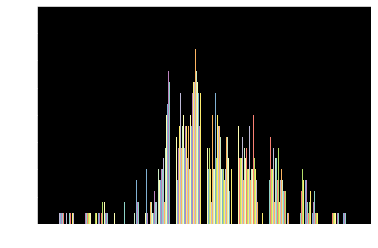

In [287]:
plt.hist(y_exact[1,:,:])

(array([[ 0.,  0.,  1.,  0.,  0.,  1.,  4., 16.,  8.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 14.,  9.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 13., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  3., 13., 12.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  2., 14., 12.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  5., 11., 11.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 11., 12.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 12., 10.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  7., 12.,  8.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  7., 10.,  9.,  2.],
        [ 0.,  0.,  1.,  0.,  1.,  1.,  9.,  8., 10.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  5., 11., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 13., 10.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  5., 16.,  7.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 15.,  7.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 10., 13.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  

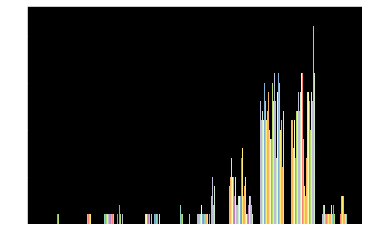

In [288]:
plt.hist(y_exact[2,:,:])

In [214]:
y_exact[0,:,:].mean().mean()

tensor(0.0456, dtype=torch.float64)

In [215]:
#maximum observed velocity.  Indication for characteristic velocity $v_f$.
y_exact[2,:,:].max()

tensor(32.9916, dtype=torch.float64)

In [216]:
#maximum observed density.  Jam density $k_j$ can not be lower than this!
y_exact[0,:,:].max()

tensor(0.0995, dtype=torch.float64)

### Normalization 

In [9]:
## no normalization to LWR-RK4 
y_min = torch.tensor([y_exact[0, :, :].min(), y_exact[1, :, :].min(), y_exact[2, :, :].min()])
y_max = torch.tensor([y_exact[0, :, :].max(), y_exact[1, :, :].max(), y_exact[2, :, :].max()])
# y_norm = torch.zeros(y_exact.shape, dtype = torch.double) 
# y_norm[0, :, :] = (y_exact[0, :, :] - y_min[0]) / (y_max[0] - y_min[0]) 
# # y_norm[1, :, :] = (y_exact[1, :, :] - y_min[1]) / (y_max[1] - y_min[1]) 
# y_norm[1, :, :] = y_exact[1, :, :]
# y_norm[2, :, :] = (y_exact[2, :, :] - y_min[2]) / (y_max[2] - y_min[2]) 

y_norm = y_exact

In [140]:
mean = torch.tensor([y_exact[0, :, :].mean(), y_exact[1, :, :].mean(), y_exact[2, :, :].mean()])
std = torch.tensor([y_exact[0, :, :].std(), y_exact[1, :, :].std(), y_exact[2, :, :].std()])
y_norm = torch.zeros(y_exact.shape, dtype = torch.double) 
y_norm[0, :, :] = (y_exact[0, :, :] - mean[0]) / std[0]
y_norm[1, :, :] = (y_exact[1, :, :] - mean[1]) / std[1]
y_norm[2, :, :] = (y_exact[2, :, :] - mean[2]) / std[2]

In [10]:
y_norm[2, :, :].max()

tensor(32.9916, dtype=torch.float64)

In [11]:
import numpy as np
#nx=350  # 
nx=120
#kj needs to be larger than k for the solution to be stable 
kj = np.ones((nx,), dtype=float) * 0.2
# kj = (kj - y_min[0].numpy()) / (y_max[0].numpy() - y_min[0].numpy()) # normalize

#characteristic velocity (m/s), corresponds to roughly 120 km/h
vf = np.ones((nx,), dtype=float) * 33
# vf = (vf - y_min[2].numpy()) / (y_max[2].numpy() - y_min[2].numpy()) # normalize

dx=300.

## change the timestep to dt = 1, previously dt = 6 with 7 mins runtime
dt=6. 
#need an output every 5 mins (300 s), so tskip = 3 with dt = 3s
tskip=50
#nt=int(3600*6/6 - 50)
#nt=7099 #6 hours (times 3600 s/hour divided by dt=3s)
nto=(y_exact.shape[1]+1) 
#nt=int(3600*nto/12/6/dt - tskip)
dtobs=300
nt=int((dtobs*nto)/dt - tskip)
print(dt,nt)

#assert int(nt/tskip) == nto

6.0 3550


In [12]:
y_max[2]

tensor(32.9916, dtype=torch.float64)

(array([[ 0.,  0.,  4.,  7.,  9., 10.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  1.,  9.,  9.,  7.,  3.,  1.,  0.,  0.],
        [ 0.,  0.,  1., 10.,  6.,  9.,  4.,  1.,  0.,  0.],
        [ 0.,  0.,  3.,  9.,  4.,  9.,  3.,  3.,  0.,  0.],
        [ 0.,  0.,  5.,  7.,  4., 10.,  2.,  2.,  1.,  0.],
        [ 0.,  1.,  1.,  4., 14.,  5.,  5.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  8.,  8.,  7.,  4.,  3.,  0.,  0.],
        [ 0.,  1.,  0.,  9.,  7.,  4.,  9.,  0.,  1.,  0.],
        [ 0.,  1.,  0., 10.,  5.,  6.,  6.,  2.,  1.,  0.],
        [ 1.,  0.,  0., 10.,  7.,  5.,  6.,  1.,  1.,  0.],
        [ 0.,  1.,  0., 11.,  8.,  6.,  3.,  1.,  1.,  0.],
        [ 0.,  1.,  0., 11.,  8.,  6.,  2.,  2.,  1.,  0.],
        [ 0.,  1.,  0., 11.,  9.,  4.,  4.,  1.,  1.,  0.],
        [ 1.,  0.,  0., 11.,  7.,  7.,  3.,  2.,  0.,  0.],
        [ 1.,  0.,  2.,  9.,  7.,  4.,  5.,  2.,  1.,  0.],
        [ 1.,  0.,  2.,  9., 10.,  4.,  3.,  1.,  0.,  1.],
        [ 0.,  1.,  0., 10., 11.,  4.,  

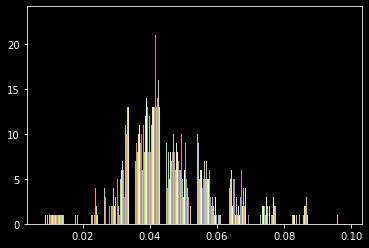

In [15]:
plt.hist(y_norm[0, :, :])

In [12]:
kj

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2])

In [13]:
vf

array([33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.,
       33., 33., 33.])

In [14]:
#import pandas as pd
import json

station_pos_idx=json.load(open("5S_station_pos_idx_dx=%04dm.json" % int(dx), "rb"))
#station_pos_idx=pd.read_json("station_pos_idx.json")
xi=list(station_pos_idx.values())

xi0=xi[0]
for p in range(len(xi)):
    xi[p] = xi[p] - xi0

#shift xi's such that model starts at first receiver
#(because observed data at this receiver is input at upstream model end)
print(xi)
#xi=xi-xi[0]
#xi

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_pos_idx_dx=0300m.json'

In [14]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

In [13]:
xi = np.array(xi) * 300

In [14]:
xi = xi / 250

In [15]:
xi = [int(x) for x in xi]

In [16]:
xi

[0,
 4,
 14,
 26,
 38,
 46,
 55,
 60,
 64,
 68,
 70,
 75,
 79,
 82,
 85,
 88,
 91,
 97,
 100,
 103,
 106,
 109,
 114,
 115,
 117,
 120,
 122,
 126,
 129,
 132,
 134]

The exact solution is provided in cars / km.  However, I changed the units from km and hours to meters and seconds.  Therefore, the density should be divided by 1000.

**Update:** Not needed, `avg_occupancy` is already given in cars/meters (check this.  They might be using miles).

In [15]:
steps=torch.tensor(np.linspace(0, nt, nt), requires_grad=True)
steps

tensor([0.0000e+00, 1.0003e+00, 2.0006e+00,  ..., 3.5480e+03, 3.5490e+03,
        3.5500e+03], dtype=torch.float64, requires_grad=True)

In [16]:
steps.shape

torch.Size([3550])

Defining the initial values of the traffic density in the model.  They need to be defined on every point on the computational grid, not just at those positions where there is data.  I am interpolating them between the sensors, and extrapolating using initial values on the end sensors.

In [19]:
from scipy.interpolate import interp1d, interpn
print(xi)
def interpolate_initial(var, t0=0):
    IM=interp1d(np.array(xi) * dx, var[t0,:].numpy(), bounds_error=False, 
                fill_value=(var[t0,0], var[t0,-1]), kind='linear') # (var[t0,0], var[t0,-1])
#     IM=interp1d(np.array(xi), var[t0,:].numpy(), bounds_error=False, 
#                 fill_value="extrapolate", kind='linear')
    print(var[t0,:])
    x=np.linspace(0, (nx-1) * dx, nx)
    return IM(x)

[0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]


In [17]:
from scipy.interpolate import interp1d
print(xi)
def interpolate_initial(var, t0=0):
    IM=interp1d(np.array(xi)*dx, var[t0,:].numpy(), bounds_error=False, 
                fill_value=(var[t0,0], var[t0,-1]), kind='linear')
    
    x=np.linspace(0, (nx-1)*dx, nx)
    return IM(x)

[0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]


In [152]:
def extrap(x, xp, yp):
    """np.interp function with linear extrapolation"""
    y = np.interp(x, xp, yp)
    print(y[x > xp[-2]])
    print((x[x>xp[-1]]-xp[-2])*(yp[-2]-yp[-3])/(xp[-2]-xp[-3]))
    print((x[x>xp[-1]]-xp[-1])*(yp[-1]-yp[-2])/(xp[-1]-xp[-2]))
    y[x < xp[0]] = yp[0] + (x[x<xp[0]]-xp[0]) * (yp[0]-yp[1]) / (xp[0]-xp[1])
    y[x > xp[-1]] = 1/4 * (yp[-4] + yp[-3] + yp[-2] + yp[-1]) + ((x[x>xp[-1]]-xp[-1])*(yp[-1]-yp[-2])/(xp[-1]-xp[-2]))
    return y

In [60]:
from scipy.interpolate import InterpolatedUnivariateSpline
# s = InterpolatedUnivariateSpline(xi, yi, k=order)
# y = s(x)
def func(var, t0=0): 
    IM=InterpolatedUnivariateSpline(np.array(xi) * dx, var[t0,:].numpy(), k = 1, ext = 3)
    x=np.linspace(0, (nx-1)*dx, nx)
    return IM(x)

In [61]:
func(y_norm[2,:])

array([31.829248  , 31.158688  , 30.488128  , 29.817568  , 29.147008  ,
       28.951428  , 28.755848  , 28.560268  , 28.364688  , 28.169108  ,
       27.973528  , 27.777948  , 27.582368  , 27.6851872 , 27.7880064 ,
       27.8908256 , 27.9936448 , 28.096464  , 28.1992832 , 28.3021024 ,
       28.4049216 , 28.5077408 , 28.61056   , 28.3736288 , 28.1366976 ,
       27.8997664 , 27.6628352 , 27.425904  , 27.1889728 , 26.9520416 ,
       26.7151104 , 26.4781792 , 26.241248  , 26.70106057, 27.16087314,
       27.62068571, 28.08049829, 28.54031086, 29.00012343, 29.459936  ,
       29.58127543, 29.70261486, 29.82395429, 29.94529371, 30.06663314,
       30.18797257, 30.309312  , 30.409896  , 30.51048   , 30.611064  ,
       30.711648  , 30.644592  , 30.577536  , 30.51048   , 30.443424  ,
       30.41362133, 30.38381867, 30.354016  , 29.95168   , 29.549344  ,
       29.50464   , 29.459936  , 29.415232  , 29.370528  , 29.71325867,
       30.05598933, 30.39872   , 29.549344  , 28.699968  , 27.85

In [130]:
extrap(np.linspace(0, (nx-1) * dx, nx), np.array(xi) * dx, np.array(y_norm[2, 0, :]))

array([31.829248  , 31.158688  , 30.488128  , 29.817568  , 29.147008  ,
       28.951428  , 28.755848  , 28.560268  , 28.364688  , 28.169108  ,
       27.973528  , 27.777948  , 27.582368  , 27.6851872 , 27.7880064 ,
       27.8908256 , 27.9936448 , 28.096464  , 28.1992832 , 28.3021024 ,
       28.4049216 , 28.5077408 , 28.61056   , 28.3736288 , 28.1366976 ,
       27.8997664 , 27.6628352 , 27.425904  , 27.1889728 , 26.9520416 ,
       26.7151104 , 26.4781792 , 26.241248  , 26.70106057, 27.16087314,
       27.62068571, 28.08049829, 28.54031086, 29.00012343, 29.459936  ,
       29.58127543, 29.70261486, 29.82395429, 29.94529371, 30.06663314,
       30.18797257, 30.309312  , 30.409896  , 30.51048   , 30.611064  ,
       30.711648  , 30.644592  , 30.577536  , 30.51048   , 30.443424  ,
       30.41362133, 30.38381867, 30.354016  , 29.95168   , 29.549344  ,
       29.50464   , 29.459936  , 29.415232  , 29.370528  , 29.71325867,
       30.05598933, 30.39872   , 29.549344  , 28.699968  , 27.85

In [52]:
k_initial["k"], k_initial["q"], k_initial["u"]

(array([0.03969096, 0.04114732, 0.04260368, 0.04406003, 0.04551639,
        0.04589956, 0.04628273, 0.04666591, 0.04704908, 0.04743225,
        0.04781542, 0.04819859, 0.04858176, 0.0481392 , 0.04769665,
        0.04725409, 0.04681153, 0.04636898, 0.04592642, 0.04548386,
        0.0450413 , 0.04459875, 0.04415619, 0.04440244, 0.0446487 ,
        0.04489495, 0.0451412 , 0.04538745, 0.04563371, 0.04587996,
        0.04612621, 0.04637246, 0.04661872, 0.04577794, 0.04493717,
        0.04409639, 0.04325561, 0.04241484, 0.04157406, 0.04073329,
        0.03972182, 0.03871035, 0.03769889, 0.03668742, 0.03567596,
        0.03466449, 0.03365302, 0.03356994, 0.03348686, 0.03340377,
        0.03332069, 0.03374994, 0.03417918, 0.03460843, 0.03503767,
        0.03543812, 0.03583857, 0.03623903, 0.03583   , 0.03542098,
        0.03754613, 0.03967128, 0.04179643, 0.04392158, 0.04554636,
        0.04717114, 0.04879591, 0.05124156, 0.05368721, 0.05613286,
        0.05663263, 0.05713241, 0.05472161, 0.05

In [18]:
k_initial={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial[c]=interpolate_initial(y_norm[n,:])
    print(k_initial[c].max())
    print(k_initial[c].shape)

0.07363054044131748
(120,)
1.9066666666666667
(120,)
31.829248000000003
(120,)


In [140]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
ti

array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
        2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
        4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
        7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
        9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
       12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
       14400., 14700., 15000., 15300., 15600., 15900., 16200., 16500.,
       16800., 17100., 17400., 17700., 18000., 18300., 18600., 18900.,
       19200., 19500., 19800., 20100., 20400., 20700., 21000.])

The boundary condition at the upstream end also need to be interpolated:

71 3
(3550,) 0.04694415598818393
(3550,) 1.49
(3550,) 32.768032


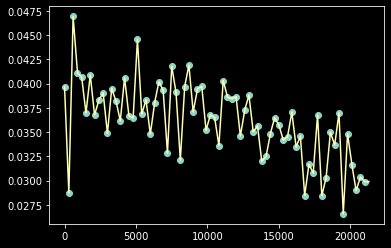

In [19]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
print(len(ti), y_norm.shape[0])
t=np.linspace(0, (nt-1)*dt, nt)
#print(len(ti), len(y_exact))
#print(t)

k_boundary={}

for n,c in enumerate(cmps):
    IMb=interp1d(np.array(ti), y_norm[n,:,0].numpy(), bounds_error=False,
             fill_value=(y_norm[n,0,0], y_norm[n,-1,0]),
             kind='linear')
    k_boundary[c]=IMb(t)
    print(k_boundary[c].shape, k_boundary[c].max())

fig2,ax2=plt.subplots()
ax2.plot(ti, y_norm[0,:,0], marker='o', linewidth=0)
ax2.plot(t, k_boundary["k"])

In [64]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
ti

array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
        2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
        4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
        7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
        9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
       12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
       14400., 14700., 15000., 15300., 15600., 15900., 16200., 16500.,
       16800., 17100., 17400., 17700., 18000., 18300., 18600., 18900.,
       19200., 19500., 19800., 20100., 20400., 20700., 21000.])

In [45]:
t=np.linspace(0, (nt-1)*dt, nt)
t

array([0.0000e+00, 6.0000e+00, 1.2000e+01, ..., 2.1282e+04, 2.1288e+04,
       2.1294e+04])

In [72]:
k_initial

{'k': array([0.03969096, 0.04114732, 0.04260368, 0.04406003, 0.04551639,
        0.04589956, 0.04628273, 0.04666591, 0.04704908, 0.04743225,
        0.04781542, 0.04819859, 0.04858176, 0.0481392 , 0.04769665,
        0.04725409, 0.04681153, 0.04636898, 0.04592642, 0.04548386,
        0.0450413 , 0.04459875, 0.04415619, 0.04440244, 0.0446487 ,
        0.04489495, 0.0451412 , 0.04538745, 0.04563371, 0.04587996,
        0.04612621, 0.04637246, 0.04661872, 0.04577794, 0.04493717,
        0.04409639, 0.04325561, 0.04241484, 0.04157406, 0.04073329,
        0.03972182, 0.03871035, 0.03769889, 0.03668742, 0.03567596,
        0.03466449, 0.03365302, 0.03356994, 0.03348686, 0.03340377,
        0.03332069, 0.03374994, 0.03417918, 0.03460843, 0.03503767,
        0.03543812, 0.03583857, 0.03623903, 0.03583   , 0.03542098,
        0.03754613, 0.03967128, 0.04179643, 0.04392158, 0.04554636,
        0.04717114, 0.04879591, 0.05124156, 0.05368721, 0.05613286,
        0.05663263, 0.05713241, 0.05472161,

In [20]:
list(k_initial.keys()) ==  cmps

True

In [127]:
tdnu = Neural_LWR_sparse2_3cmp(nx, dx, dt, kj, vf, xi, tskip, plm = "none", 
                          initial=k_initial, boundary=k_boundary, 
                               fix_vf=False, parstep=10)

In [57]:
tdnu = Neural_LWR_sparse2_3cmp(nx, dx, dt, kj, vf, xi, tskip, y_max, y_min,  
                          initial=k_initial, boundary=k_boundary, 
                               fix_vf=False, parstep=10)

In [63]:
#torch.optim.lr_scheduler.StepLR?
#torch.optim.SGD?

In [128]:
optimizer = torch.optim.Adam(tdnu.parameters(), lr=0.02)
#optimizer = torch.optim.SGD(tdnu.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma=0.95) #0.95 #step_size=1
#torch.optim.lr_scheduler.StepLR?

- reduce time step $\Delta t$
- try different optimizer
- reduce learning rate decay (step_size in scheduler) - 500 epochs

In [129]:
num_epochs = 100
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [130]:
-5.2778e-05 * 3

-0.000158334

In [131]:
# y_approx = tdnu(steps[0:68*tskip].long())
y_approx = tdnu(k_initial, k_boundary, steps[0:68*tskip].long())
print(y_exact[:,0:68].shape, y_approx.shape)
# print(y_exact[:,0:68].shape, y_approx.shape)

torch.Size([3, 68, 31]) torch.Size([3, 68, 31])


In [132]:
steps[0:68*tskip].shape

torch.Size([3400])

In [133]:
y_approx.isnan().any()

tensor(False)

tensor([32.0975, 24.8634, 24.0432, 23.9639, 24.4941, 24.9944, 25.4882, 25.7099,
        25.8270, 25.7934, 25.6880, 25.2627, 24.8487, 24.5099, 24.3687, 24.2787,
        24.2803, 24.4099, 24.5346, 24.6274, 24.7740, 24.8736, 25.0687, 25.1153,
        25.2042, 25.2853, 25.3555, 25.4326, 25.4621, 25.4474, 25.4015],
       dtype=torch.float64, grad_fn=<SliceBackward>)
tensor([32.0975, 29.8623, 28.6553, 28.6106, 26.5095, 29.4599, 30.9352, 31.0693,
        30.7564, 30.6222, 31.1140, 30.7564, 30.1752, 27.2694, 30.2199, 30.6222,
        31.0693, 30.7564, 30.7564, 28.7894, 29.6388, 28.5659, 30.3540, 28.2529,
        28.6106, 28.8341, 29.9964, 30.2199, 31.1140, 29.2364, 22.0391],
       dtype=torch.float64)
0.03707457085716906


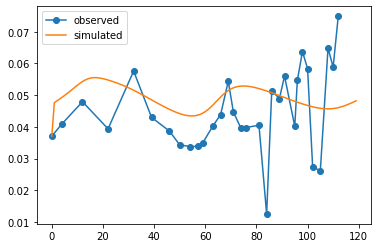

In [134]:
%matplotlib inline
#y_approx
tp=30
print(y_approx[2,tp,:])
print(y_norm[2,tp,:])
fig,ax=plt.subplots()
ax.plot(xi, y_norm[0,tp,:].detach(), label='observed', marker='o')
#ax.plot(xi, y_approx[0].detach(), label='trained')
ax.plot(tdnu.k[tp*tskip].detach(), label='simulated')
print(k_boundary["k"][tp*tskip])
ax.legend()

In [135]:
print(y_approx.shape, y_norm.shape)
loss=loss_fun(y_approx, y_norm[:,0:68,:])
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape
print("Initial loss: %e" % loss)
loss_history=[loss.item()]

torch.Size([3, 68, 31]) torch.Size([3, 71, 31])
Initial loss: 5.692691e+00


In [172]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = (y_approx[0, :, :] * std[0] + mean[0])
y_approx_actual[1, :, :] = (y_approx[1, :, :] * std[1] + mean[1])
y_approx_actual[2, :, :] = (y_approx[2, :, :] * std[2] + mean[2]) 

loss=loss_fun(y_approx_actual, y_exact[:, :68,:]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 3.468313e+00


In [260]:
1.727673e-13

1.727673e-13

In [136]:
history=[]
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = tdnu(k_initial, k_boundary, steps[0:68*tskip].long())
    loss = loss_fun(y_approx, y_norm[:,0:68,:])
    loss_history.append(loss.item())
    if loss.item() < min_loss:
        best_model_lwr = tdnu
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    tqdm_epochs.set_postfix({'loss': loss.item()}) 
    
    scheduler.step() 

100%|██████████| 100/100 [07:30<00:00,  4.50s/it, loss=0.91]


In [137]:
y_approx.shape

torch.Size([3, 68, 31])

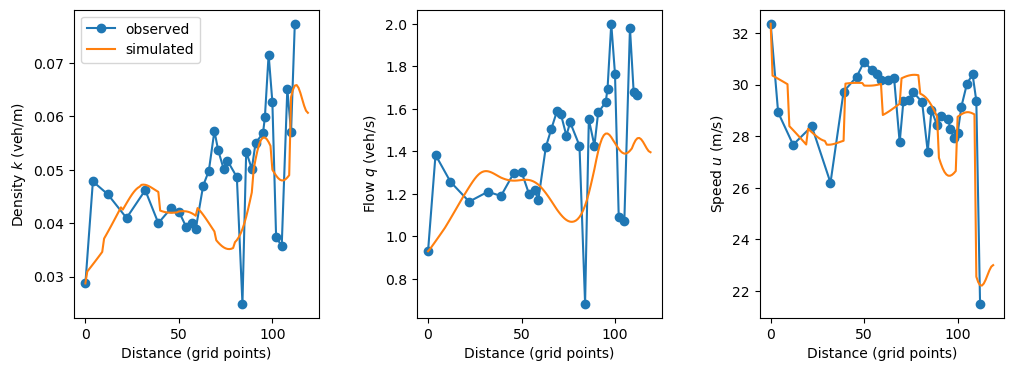

In [68]:
tp=1
#print(y_approx[tp])
#print(y_exact[tp])
plt.style.use('default')
fig3,ax3=plt.subplots(ncols=3, nrows=1, figsize=(12,4))
fig3.subplots_adjust(wspace=0.4)

varplot={0: tdnu.k, 1: tdnu.q, 2: tdnu.u}
label={0: "Density $k$ (veh/m)",
       1: "Flow $q$ (veh/s)",
       2: "Speed $u$ (m/s)"}
for n in range(3):
    ax3[n].plot(xi, y_exact[n,tp,:].detach(), label='observed', marker='o')
    if n==6: 
        ax3[n].plot(varplot[n][tp*tskip].detach(), label='simulated') 
    else: 
        ax3[n].plot(varplot[n][tp*tskip].detach(), label='simulated')
    #print(k_boundary[tp*tskip])
    if n==0:
        ax3[n].legend()
    ax3[n].set_xlabel("Distance (grid points)")
    ax3[n].set_ylabel(label[n])
#ax3.set_ylim(0, 0.3)
fig3.savefig("kqu_parstep10.png", dpi=300)

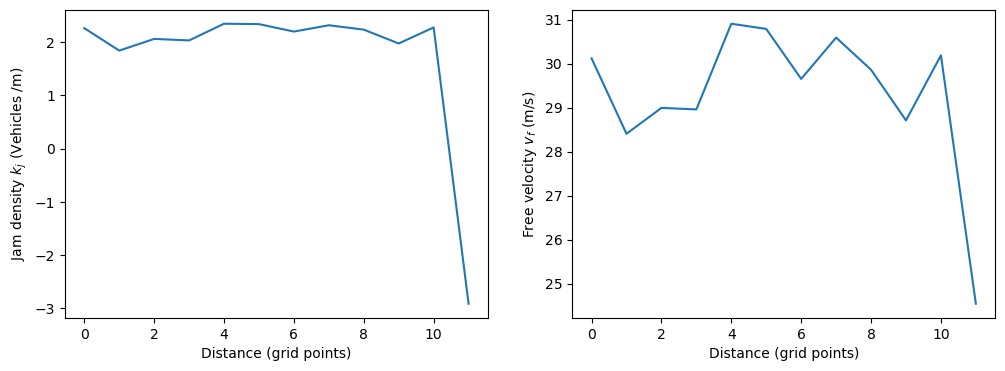

In [153]:
fig4,ax4=plt.subplots(ncols=2, figsize=(12,4))
ax4[0].plot((tdnu.kappa).detach())
ax4[1].plot((tdnu.vf).detach())
[ax4[n].set_xlabel("Distance (grid points)") for n in range(2)]
ax4[0].set_ylabel("Jam density $k_j$ (Vehicles /m)")
ax4[1].set_ylabel("Free velocity $v_f$ (m/s)")
fig4.savefig("kj_vf_parstep10.png", dpi=300)

In [80]:
from ipywidgets import widgets
import plotly.graph_objects as go
import plotly
plotly.io.templates.default = 'plotly_dark'

In [81]:
y_exact.shape

torch.Size([3, 71, 31])

In [82]:
tslider=widgets.IntSlider(
    value=0.0, min=0.0, max=y_exact.shape[1]-1, step=1, description='Time Step', continuous_update=False)

tp=0
trace1=go.Scatter(y=(tdnu.k[tp*tskip] * (y_max[0] - y_min[0]) + y_min[0]).detach(), mode='lines', name='simulated')
trace2=go.Scatter(x=xi, y=y_exact[0,tp,:].detach(), mode='lines+markers', name='observed', line={"width": 2})

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(trace2, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)

fig.update_yaxes(range=[0, 0.3], row=1, col=1)
fig.update_layout(height=500, width=800)
fig.update_layout(title="%d minutes" % (tp*tskip/60*dt))
fig.update_layout(xaxis_title="Distance (km)", yaxis_title="Density")

fo=go.FigureWidget(fig)
def update_traces(value):
    tp=value["new"]
    fo.data[1].y=(tdnu.k[tp*tskip] * (y_max[0] - y_min[0]) + y_min[0]).detach()
    fo.data[0].x=xi
    fo.data[0].y=y_exact[0,tp,:].detach()
    fo.update_layout(title="%d minutes" % (tp*tskip/60*dt))

tslider.observe(update_traces, names='value')

#fo.data[0].y=td.k[300,:]
display(tslider)
display(fo)

IntSlider(value=0, continuous_update=False, description='Time Step', max=70)

FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines+markers',
              'name'…

In [83]:
y_exact.shape

torch.Size([3, 71, 31])

In [69]:
k_initial2={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial2[c]=interpolate_initial(y_norm[n,:], t0=68)
    print(k_initial2[c].max())

0.05183321634663276
1.5333333333333334
32.320992000000004


In [70]:
k_boundary2 = {var: k_boundary[var][68*tskip:] for var in k_boundary.keys()}

In [71]:
k_boundary2["k"].shape
k_initial2["k"].shape

(120,)

In [372]:
tdnu = best_model_lwr

In [72]:
idx=torch.arange(tdnu.nx) / tdnu.parstep
hkappa=tdnu.kappa[idx.long()]
hvf=tdnu.vf[idx.long()]
#hkappa.shape

In [73]:
tdnu.kappa

Parameter containing:
tensor([0.3650, 0.2702, 0.2995, 0.2903, 0.4257, 0.4177, 0.3319, 0.4026, 0.3473,
        0.2833, 0.3735, 0.2114], dtype=torch.float64, requires_grad=True)

In [77]:
hkappa

tensor([0.3650, 0.3650, 0.3650, 0.3650, 0.3650, 0.3650, 0.3650, 0.3650, 0.3650,
        0.3650, 0.2702, 0.2702, 0.2702, 0.2702, 0.2702, 0.2702, 0.2702, 0.2702,
        0.2702, 0.2702, 0.2995, 0.2995, 0.2995, 0.2995, 0.2995, 0.2995, 0.2995,
        0.2995, 0.2995, 0.2995, 0.2903, 0.2903, 0.2903, 0.2903, 0.2903, 0.2903,
        0.2903, 0.2903, 0.2903, 0.2903, 0.4257, 0.4257, 0.4257, 0.4257, 0.4257,
        0.4257, 0.4257, 0.4257, 0.4257, 0.4257, 0.4177, 0.4177, 0.4177, 0.4177,
        0.4177, 0.4177, 0.4177, 0.4177, 0.4177, 0.4177, 0.3319, 0.3319, 0.3319,
        0.3319, 0.3319, 0.3319, 0.3319, 0.3319, 0.3319, 0.3319, 0.4026, 0.4026,
        0.4026, 0.4026, 0.4026, 0.4026, 0.4026, 0.4026, 0.4026, 0.4026, 0.3473,
        0.3473, 0.3473, 0.3473, 0.3473, 0.3473, 0.3473, 0.3473, 0.3473, 0.3473,
        0.2833, 0.2833, 0.2833, 0.2833, 0.2833, 0.2833, 0.2833, 0.2833, 0.2833,
        0.2833, 0.3735, 0.3735, 0.3735, 0.3735, 0.3735, 0.3735, 0.3735, 0.3735,
        0.3735, 0.3735, 0.2114, 0.2114, 

In [78]:
tdnp = Neural_LWR_sparse2_3cmp(nx, dx, dt, hkappa, hvf, xi, tskip, y_max, y_min,  
                          initial=k_initial2, boundary=k_boundary2,
                          fix_vf=False, parstep=10)

C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_9916/3266757490.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kappa=torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_9916/3266757490.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)


In [79]:
y_predicted=tdnp(steps[68*tskip:]).detach()

In [55]:
y_predicted[:, 1:, :].shape

torch.Size([3, 3, 31])

In [80]:
loss=loss_fun(y_predicted, y_exact[:, 68:, :]) 
print("Final actual loss: %e" % loss)

Final actual loss: 2.931564e-01


In [115]:
# ## re-transform: testing loss without normalization (used for comparison)
# y_predicted_actual = torch.zeros(y_predicted.shape) 
# y_predicted_actual[0, :, :] = y_predicted[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
# y_predicted_actual[1, :, :] = y_predicted[1, :, :]
# y_predicted_actual[2, :, :] = y_predicted[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

# loss=loss_fun(y_predicted_actual, y_exact[:, 68:, :]) 
# print("Final actual loss: %e" % loss) 

Final actual loss: 5.296795e-01


In [160]:
3.897261e-01

0.3897261

In [90]:
y_predicted.shape

torch.Size([3, 3, 31])

In [96]:
steps[68*tskip:].shape

torch.Size([150])

In [91]:
station_names=list(json.load(open("5S_station_names.json", "rb")).values())
record_times=json.load(open("5S_record_times.json", "r"))
#record_times

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_names.json'

In [92]:
y_exact.shape

torch.Size([3, 71, 31])

In [93]:
#gridspec.GridSpec?
#plt.subplots?

In [344]:
xd=np.arange(0., tdnu.nx*tdnu.dx, tdnu.dx) / 1.e3
xd

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25,
       31.5 , 31.75,

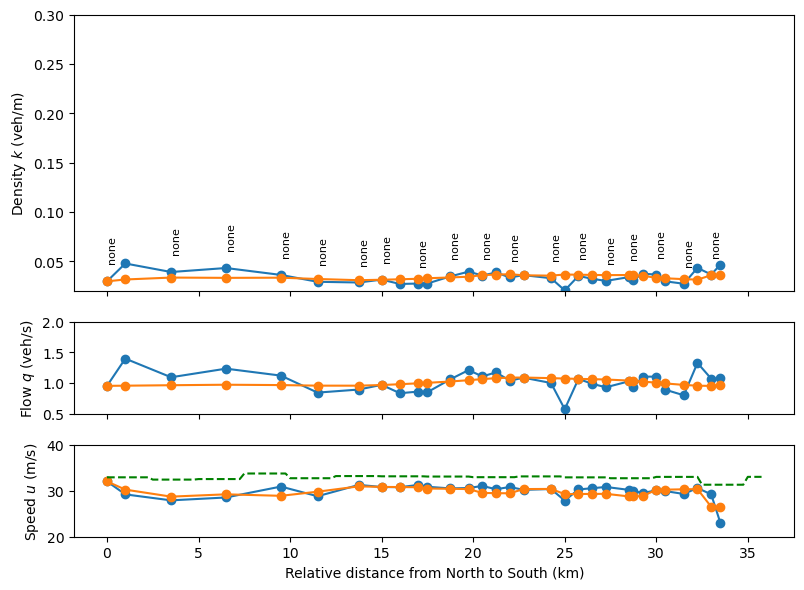

In [345]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]*dx/1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0.02, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    if n==1: 
        ax4[n].plot(fwyp, y_norm[n,tp,:].detach(), label='observed', marker='o')
        ax4[n].plot(fwyp, y_predicted[n,tp-68,:].detach(), label='predicted', marker='o') 
    else: 
        ax4[n].plot(fwyp, (y_norm[n,tp,:]).detach(), label='observed', marker='o')
        ax4[n].plot(fwyp, (y_predicted[n,tp-68,:]).detach(), label='predicted', marker='o')
#     if n==0:
# #         ax4[n].set_title(record_times[tp])
#         ax4[n].plot(xd, (hkappa).detach(), label="$k_j$", color='green', linestyle='dashed')
#         ax4[n].legend(loc="upper left")
    if n==2:
        ax4[n].plot(xd, (hvf).detach(), label="$v_f$", color='green', linestyle='dashed')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
    ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

    lastpoint=-100
    if n==0:
        for p in range(len(xi)):
            if (fwyp[p] - lastpoint) > 1.:
                ax4[n].text(fwyp[p], (y_norm[n,tp,:]).detach()[p]+0.02, "none", rotation=90, fontsize=8)
                lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)

In [165]:
hkappa

tensor([ 2.2614,  2.2614,  2.2614,  2.2614,  2.2614,  2.2614,  2.2614,  2.2614,
         2.2614,  2.2614,  1.8393,  1.8393,  1.8393,  1.8393,  1.8393,  1.8393,
         1.8393,  1.8393,  1.8393,  1.8393,  2.0592,  2.0592,  2.0592,  2.0592,
         2.0592,  2.0592,  2.0592,  2.0592,  2.0592,  2.0592,  2.0306,  2.0306,
         2.0306,  2.0306,  2.0306,  2.0306,  2.0306,  2.0306,  2.0306,  2.0306,
         2.3443,  2.3443,  2.3443,  2.3443,  2.3443,  2.3443,  2.3443,  2.3443,
         2.3443,  2.3443,  2.3370,  2.3370,  2.3370,  2.3370,  2.3370,  2.3370,
         2.3370,  2.3370,  2.3370,  2.3370,  2.1968,  2.1968,  2.1968,  2.1968,
         2.1968,  2.1968,  2.1968,  2.1968,  2.1968,  2.1968,  2.3154,  2.3154,
         2.3154,  2.3154,  2.3154,  2.3154,  2.3154,  2.3154,  2.3154,  2.3154,
         2.2331,  2.2331,  2.2331,  2.2331,  2.2331,  2.2331,  2.2331,  2.2331,
         2.2331,  2.2331,  1.9732,  1.9732,  1.9732,  1.9732,  1.9732,  1.9732,
         1.9732,  1.9732,  1.9732,  1.97